In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from nilearn.signal import clean
import pandas as pd
import seaborn as sns
from sklearn.cross_decomposition import PLSCanonical
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Initialize
np.random.seed(42)  # Reproducibility
PATH = '...'  # Path to the data

Custom functions

In [ ]:
def map_divergent(X, cmap):
    colors_div = sns.color_palette(cmap, n_colors=100)
    X_min = np.min(X)
    X_max = np.max(X)
    X_scaled = ((X-X_min)/(X_max-X_min)*99).astype(int)
    clrs = []
    for c in X_scaled:
        clrs.append(colors_div[c])
    return clrs


In [40]:
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    res = (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1) *
                                               np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return res


Load data

In [ ]:
# Load genetic data
df_cnv = pd.read_csv(PATH + '....csv', low_memory=False)  # Load CNV data
df_cnv = df_cnv[df_cnv['TYPE'].isin(['DEL', 'DUP', 'CTRL', 'BOTH'])]  # Filter for relevant types
idx_cnv = df_cnv[df_cnv['TYPE'].isin(['DEL', 'DUP', 'BOTH'])].SampleID.values  # Get sample IDs for CNV
df_cnv.set_index('SampleID', inplace=True)  # Set SampleID as index
df_cnv = df_cnv.loc[:, ['TYPE', 'sum_loeuf_inv', 'n_genes', 'gene_id']] # Select relevant columns

In [ ]:
# Load clean data
df_brain = pd.read_csv(PATH + '....csv', index_col=0)  # Load brain data
df_phens = pd.read_csv(PATH + '....csv', index_col=0)  # Load phenotypic data
df_cov = pd.read_csv(PATH + '....csv', index_col=0)  # Load covariate data

Subset to common subjects

In [ ]:
idx_str = df_brain.index
idx_phens = df_phens.index
idx_genetic = df_cnv.index
idx_cov = df_cov.index

idx_all = list(set(idx_str) & set(idx_phens) & set(idx_genetic) & set(idx_cov))
idx_cnv = np.intersect1d(idx_cnv, idx_all)
idx_ctrl = np.setdiff1d(idx_all, idx_cnv)


In [ ]:
df_cnv = df_cnv.loc[idx_all, :]
df_brain = df_brain.loc[idx_all, :]
df_phens = df_phens.loc[idx_all, :]
df_cov = df_cov.loc[idx_all, :]

Regress out covariates

In [ ]:
df_brain[:] = clean(df_brain.values, confounds=df_cov.loc[:, ['interview_age', 'sex',
                                                              'volume', 'scanner']].values,
                    detrend=False, standardize=False)  # Clean brain data
df_phens[:] = clean(df_phens.values, confounds=df_cov.loc[:, ['interview_age',
                                                              'sex']].values,
                    detrend=False, standardize=False)  # Clean phenotypic data

PLS machinery

In [ ]:
# Prepare data
scaler = StandardScaler()

# Z-score based on CTRL
x_ctrl = df_brain.values.astype('float')[df_cnv['TYPE'] == 'CTRL']  # Get CTRL data
x_ctrl_ss = scaler.fit_transform(x_ctrl)  # Standardize CTRL data
x_del = df_brain.values.astype('float')[df_cnv['TYPE'].isin(['DEL', 'BOTH'])]  # Get DEL data
x_del_ss = scaler.transform(x_del)  # Standardize DEL data
x_dup = df_brain.values.astype('float')[df_cnv['TYPE'].isin(['DUP', 'BOTH'])]  # Get DUP data
x_dup_ss = scaler.transform(x_dup)  # Standardize DUP data

y_ctrl = df_phens.values.astype('float')[df_cnv['TYPE'] == 'CTRL']
y_ctrl_ss = scaler.fit_transform(y_ctrl)
y_del = df_phens.values.astype('float')[df_cnv['TYPE'].isin(['DEL', 'BOTH'])]
y_del_ss = scaler.transform(y_del)
y_dup = df_phens.values.astype('float')[df_cnv['TYPE'].isin(['DUP', 'BOTH'])]
y_dup_ss = scaler.transform(y_dup)

In [ ]:
# Reduce data with PCA
pca_x = PCA(n_components=50)  # PCA for brain data
pca_y = PCA(n_components=50)  # PCA for phenotypic data
# Fit PCA on CTRL brain data and transform all data
# Note: PCA is fitted on CTRL data only, not on DEL or DUP
x_ctrl_pca = pca_x.fit_transform(x_ctrl_ss)
x_del_pca = pca_x.transform(x_del_ss)
x_dup_pca = pca_x.transform(x_dup_ss)
# Fit PCA on CTRL phenotypic data and transform all data
# Note: PCA is fitted on CTRL data only, not on DEL or DUP
y_ctrl_pca = pca_y.fit_transform(y_ctrl_ss)
y_del_pca = pca_y.transform(y_del_ss)
y_dup_pca = pca_y.transform(y_dup_ss)

In [ ]:
# Fit Canonical PLS model
ndim = 3  # Number of components
pls = PLSCanonical(n_components=ndim, scale=False, max_iter=1000, tol=1e-5)  # Initialize PLS model
x_score_ctrl, y_score_ctrl = pls.fit_transform(x_ctrl_pca, y_ctrl_pca)  # Fit PLS model on CTRL data

In [ ]:
# Extract PLS parameters
x_rotations = pls.x_rotations_
y_rotations = pls.y_rotations_

In [ ]:
# Calculate PLS scores
x_score_ctrl = np.dot(x_ctrl_pca, x_rotations)
y_score_ctrl = np.dot(y_ctrl_pca, y_rotations)

x_score_del = np.dot(x_del_pca, x_rotations)
y_score_del = np.dot(y_del_pca, y_rotations)

x_score_dup = np.dot(x_dup_pca, x_rotations)
y_score_dup = np.dot(y_dup_pca, y_rotations)


Cohen's d analysis

In [57]:
x_coh_del = []
y_coh_del = []
x_coh_dup = []
y_coh_dup = []

for i in range(ndim):
    x_coh_del.append(cohen_d(x_score_del[:, i], x_score_ctrl[:, i]))
    y_coh_del.append(cohen_d(y_score_del[:, i], y_score_ctrl[:, i]))
    x_coh_dup.append(cohen_d(x_score_dup[:, i], x_score_ctrl[:, i]))
    y_coh_dup.append(cohen_d(y_score_dup[:, i], y_score_ctrl[:, i]))

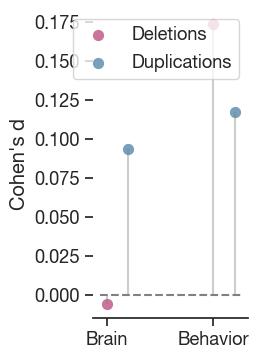

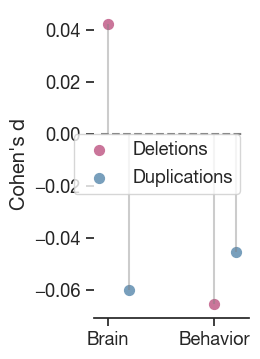

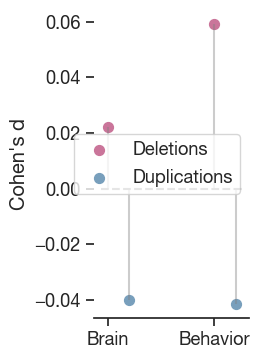

In [ ]:
# Plotting dumbbell plots of Cohen's d for each PLS dimension
for i in range(ndim):
    # Create a dataframe
    value1_x = x_coh_del[i]
    value2_x = x_coh_dup[i]
    value1_y = y_coh_del[i]
    value2_y = y_coh_dup[i]

    # Create a figure
    sns.set_theme(style="ticks", palette="colorblind", font_scale=1.2,
              font='Helvetica Neue', rc={"axes.spines.right": False,
                                         "axes.spines.top": False,
                                         "axes.spines.left": False})
    fig, ax = plt.subplots(1, figsize=(2, 4))
    # The horizontal plot is made using the hline function
    plt.vlines(x=0, ymin=np.min([0, value1_x]),
           ymax=np.max([0, value1_x]), color='grey', alpha=0.4)
    plt.scatter(y=value1_x, x=0,
            alpha=1, label='Deletions', s=50)
    plt.vlines(x=0.2, ymin=np.min([0, value2_x]),
           ymax=np.max([0, value2_x]), color='grey', alpha=0.4)
    plt.scatter(y=value2_x, x=0.2,
            alpha=1, label='Duplications', s=50)
    
    plt.vlines(x=1, ymin=np.min([0, value1_y]),
           ymax=np.max([0, value1_y]), color='grey', alpha=0.4)
    plt.scatter(y=value1_y, x=1,
            alpha=1, s=50)
    plt.vlines(x=1.2, ymin=np.min([0, value2_y]),
           ymax=np.max([0, value2_y]), color='grey', alpha=0.4)
    plt.scatter(y=value2_y, x=1.2,
            alpha=1, s=50)
    plt.legend()

    # Add title and axis names
    plt.xticks([0, 1], ['Brain', 'Behavior'])
    plt.title("")
    plt.ylabel("Cohen's d")
    plt.xlabel('')
    plt.hlines(0,  ax.get_xlim()[0], ax.get_xlim()[1], colors='grey', linestyles='dashed')
    # Show the graph
    plt.show()